In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd
import imageio

from utils import general_utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
configs_settings = {
    "full":{
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 80,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 20,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 100,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     },
    
    "sil":{
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 0,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 0,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 0,
            "lap_smoothness_lam": 0,
            "normal_consistency_lam": 0
         }
     },

    "sil_l2": {
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 0,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 0,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 100,
            "lap_smoothness_lam": 0,
            "normal_consistency_lam": 0
         }
     },
    
    "sil_l2_smooth": {
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 0,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 0,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 100,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     }, 
    
    "sil_l2_smooth_vsym": {
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 0,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 20,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 100,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     }, 
    
    "sil_l2_smooth_isym": {
         "training": {
            "img_sym_num_azim": 3,
            "img_sym_lam": 80,
            "img_sym_bias": 0.0005,
            "sil_lam": 10,
            "vertex_sym_lam": 0,
            "vertex_sym_bias": 0.0005,
            "vertex_asym": True,
            "l2_lam": 100,
            "lap_smoothness_lam": 10,
            "normal_consistency_lam": 10
         }
     },    

}
    

In [5]:
dataset = "shapenet"
class_name = "02691156"
instance = "d3f2dcf27000283799d9d900afe054b8"
cfg_path = "configs/final_refinement_params.yaml"


if dataset == "pix3d":
    rec_dir_name = "pix3d"
    img_dir_name = "pix3d_images_processed_filtered"
else:
    rec_dir_name = "pytorch3d_renders"
    img_dir_name = "pytorch3d_shapenet_renders"
input_img_dir = "data/input_images/{}/{}/rgba".format(img_dir_name, class_name)
input_img_path = os.path.join(input_img_dir, "{}.png".format(instance))
input_mesh_path = "/home/svcl-oowl/brandon/research/occupancy_networks/out/{}/{}/generation/meshes/{}.obj".format(rec_dir_name, class_name, instance)
gt_pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))[instance]
device = torch.device("cuda:0")

print(input_img_path)
print(input_mesh_path)
pprint.pprint(gt_pose_dict)

data/input_images/pytorch3d_shapenet_renders/02691156/rgba/d3f2dcf27000283799d9d900afe054b8.png
/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/02691156/generation/meshes/d3f2dcf27000283799d9d900afe054b8.obj
{'azim': 250.21241760253906, 'dist': 1.0, 'elev': 40.0}


full


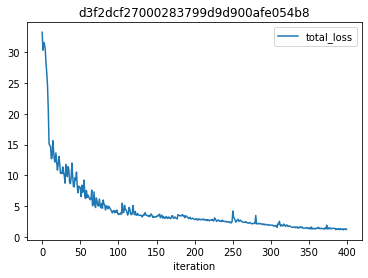

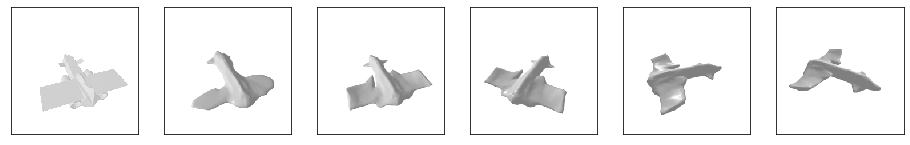

sil_l2_smooth_vsym


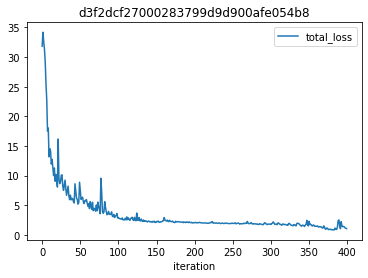

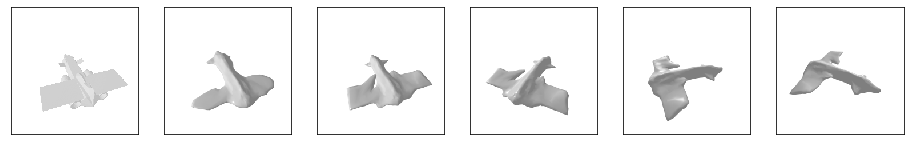

sil_l2_smooth_isym


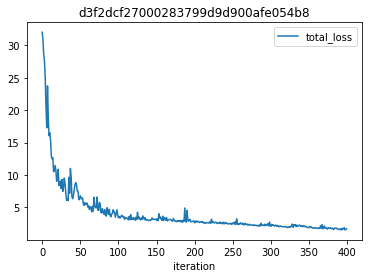

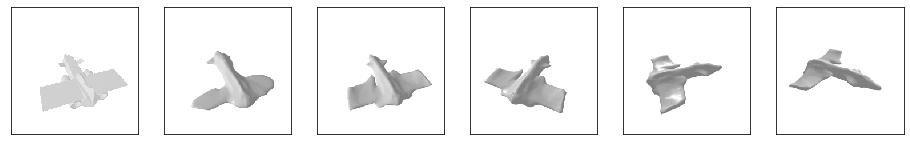

sil


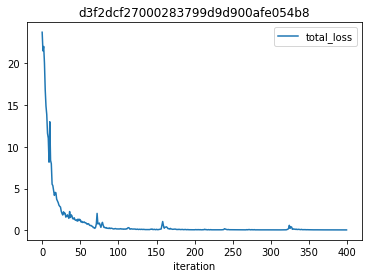

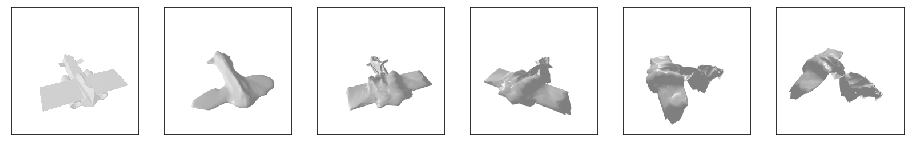

sil_l2


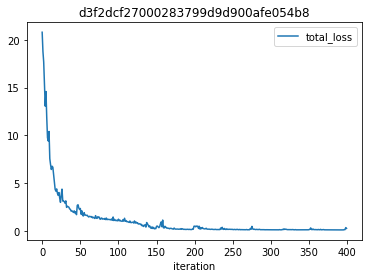

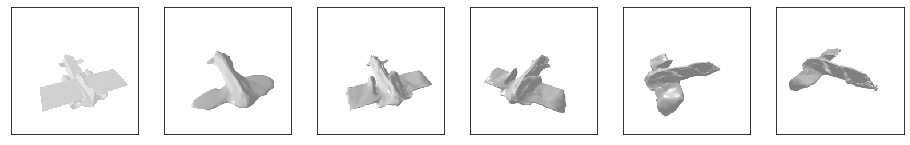

sil_l2_smooth


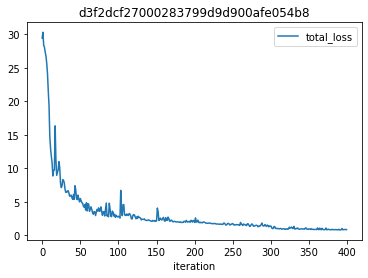

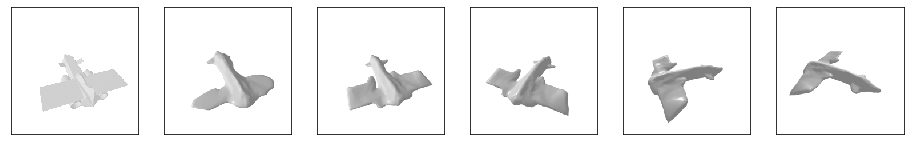

In [6]:
input_image = np.asarray(Image.open(input_img_path))
mask = np.asarray(input_image)[:,:,3] > 0
with torch.no_grad():
    input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)
elev = gt_pose_dict["elev"]
azim = gt_pose_dict["azim"]
_, _, dist, _, _ = brute_force_estimate_dist(input_mesh, mask, azim, elev, 40, device)

#cfgs_to_use = ["sil_l2_smooth", "sil_l2_smooth_vsym", "sil_l2_smooth_isym"]
#cfgs_to_use = ["full", "sil", "sil_l2"]
cfgs_to_use = ["full", "sil_l2_smooth_vsym", "sil_l2_smooth_isym", "sil", "sil_l2", "sil_l2_smooth"]

for config_name in cfgs_to_use:
    print(config_name)
    cfg = general_utils.load_config_dict(configs_settings[config_name], "configs/default.yaml")
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)

    mesh_refiner = MeshRefiner(cfg, device)
    refined_mesh, refinement_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
    refinement_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance))

    visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)

    print("===========================================================================================")